In [1]:
from traitlets.config.manager import BaseJSONConfigManager
#path = "/home/damian/miniconda3/envs/rise_latest/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager()
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
              'scroll': True
})

{'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'sky',
 'transition': 'zoom'}

# Lecture 1: Introduction to Uncertainty Quantification

## Today
- What is UQ? 
- polynomial approximation
- parameters estimation

## Uncertainty quantification

<img src='entire_process.png'>

## Uncertainty quantification

Numerical simulations assume models of real world; these models pick **uncertainties**

- In coefficients
- In right-hand sides
- Models are approximate


## Forward and inverse problems

UQ splits into two major branches: **forward** and inverse **problems**

Roughly speaking, UQ divides into two major branches, forward and inverse problems. 




## Forward problems

In the forward propagation of uncertainty, we have a known model F for a system of interest. 
We model its inputs $X$ as a random variable and wish to understand the output random variable 
$$Y = F(X)$$
(also denoted $Y \vert X$) and reads $Y$ given $X$. 

Also, this is related to **sensitivity analysis** (how random variations in $X$ influence variation in $Y$).

 


## Inverse problems


In inverse problems, $F$ is a forward model, but $Y$ is observed data, and we want to find the input data $X$ 

such that $F(X) = Y$, i.e. we want $X \vert Y$ instead of $Y \vert X$. 

Inverse problems are typically **ill-posed** in the usual sense, so we need an **expert** (or **prior**) 
about what a good solution $X$ might be.

**Bayesian perspective** becomes the method of choice, but this requires the representation of high-dimensional distributions.

$$p(X \vert Y) = \frac{p(Y \vert X) p(X)}{p(Y)}.$$



## Approximation of multivariate functions

If we want to do efficient UQ (not only Monte-Carlo) we need efficient tools for the approximation of multivariate functions.

Consider orthogonal polynomials $\{p_n\}$
$$
\langle p_n,\, p_m \rangle = \int_a^bp_n(x)p_m(x)w(x)\,dx=\delta_{nm}h_n.
$$
 - Chebyshev polynomials of the first kind, $(a,\,b)=(-1,\,1)$, $w(x)=\left(1-x^2\right)^{-1/2}$
 - Hermite polynomials (mathematical or probabilistic), $(a,\,b)=(-\infty,\,+\infty)$, $w(x)=\frac1{\sqrt{2\pi}}\exp\left(-x^2/2\right)$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev as T
from numpy.polynomial.hermite import hermval
%matplotlib inline

def p_cheb(x, n):
    """
    RETURNS T_n(x)
    value of not normalized Chebyshev polynomials
    $\int \frac1{\sqrt{1-x^2}}T_m(x)T_n(x) dx = \frac\pi2\delta_{nm}$
    """
    return T.basis(n)(x)

def p_herm(x, n):
    """
    RETURNS H_n(x)
    value of non-normalized Probabilistic polynomials
    """
    cf = np.zeros(n+1)
    cf[n] = 1
    return (2**(-float(n)*0.5))*hermval(x/np.sqrt(2.0), cf)

def system_mat(pnts, maxn, poly):
    """
    RETURNS system matrix
    """
    A = np.empty((pnts.size, maxn), dtype=float)
    for i in range(maxn):
        A[:, i] = poly(pnts, i)
    return A

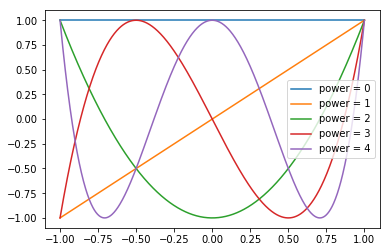

In [4]:
x = np.linspace(-1, 1, 1000)
data = []
for i in range(5):
    data.append(x)
    data.append(p_cheb(x, i))
       

plt.plot(*data)
plt.legend(["power = {}".format(i) for i in range(len(data))]);

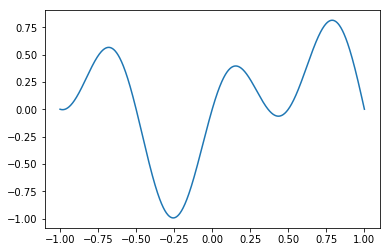

In [5]:
def complex_func(x):
    return np.sin(2.0*x*np.pi)*np.cos(0.75*(x+0.3)*np.pi)

plt.plot(x, complex_func(x));

Now, let's approximate the function with polynomials taking different maximal power $n$ and the corresponding number of node points
$$
f(x)\approx\hat f(x)=\sum_{i=0}^n\alpha_i p_i(x)
$$

In [6]:
n = 6
M = n
nodes = np.linspace(-1, 1, M)
RH = complex_func(nodes)
A = system_mat(nodes, n, p_cheb)
if n == M:
    alpha = np.linalg.solve(A, RH)
else:
    alpha = np.linalg.lstsq(A, RH)[0]
print("α = {}".format(alpha))

α = [ 0.14310061 -0.43250604  0.20112419 -0.25853987 -0.3442248   0.69104591]


In [5]:
def calc_apprximant(poly, alpha, x):
    """
    RETURNS values of approximant in points x
    """
    n = len(alpha)
    y = np.zeros_like(x)
    for i in range(n):
        y[...] += poly(x, i)*alpha[i]
        
    return y

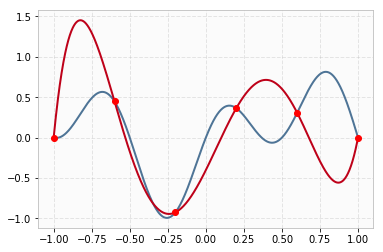

In [6]:
y = complex_func(x)
approx_y = calc_apprximant(p_cheb, alpha, x)
plt.plot(x, y, x, approx_y, nodes, RH, 'ro');

Approximate value of the error
$$
\varepsilon=
\|f-\hat f\|_\infty\approx\max_{x\in \mathcal X}\bigl|f(x)-\hat f(x)\bigr|
$$

In [7]:
epsilon = np.linalg.norm(y - approx_y, np.inf)
print("ε = {}".format(epsilon))

ε = 1.29862384085


If we take another set of polynomials, the result of the approximation will be the same (coefficients $\alpha$ will be different of course).

α = [ -5.5075967498 125.0841293387 -13.3667434932  95.7122685731  -2.7537983749  11.0567346346]
ε = 1.29862384085


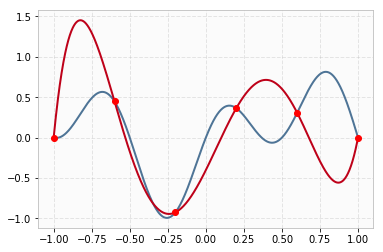

In [8]:
A = system_mat(nodes, n, p_herm)
if n == M:
    alpha = np.linalg.solve(A, RH)
else:
    alpha = np.linalg.lstsq(A, RH)[0]
print("α = {}".format(alpha))

approx_y = calc_apprximant(p_herm, alpha, x)
plt.plot(x, y, x, approx_y, nodes, RH, 'ro')

epsilon = np.linalg.norm(y - approx_y, np.inf)
print("ε = {}".format(epsilon))

Now, what will change if we take another set of node points?

α = [ -8.1775607646  69.1215115957 -19.6182987491  52.9293336076  -4.0336945947   6.1756528036]
ε_cheb = 0.821280126616


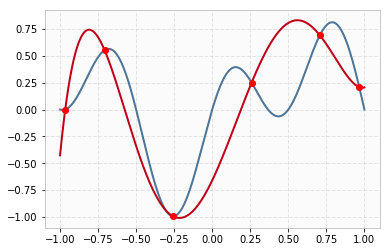

In [9]:
nodes = np.cos((2.0*np.arange(M) + 1)/M*0.5*np.pi)
RH = complex_func(nodes)
A = system_mat(nodes, n, p_herm)
alpha = np.linalg.solve(A, RH)
print("α = {}".format(alpha))

approx_y = calc_apprximant(p_herm, alpha, x)
plt.plot(x, y, x, approx_y, nodes, RH, 'ro')

epsilon_cheb = np.linalg.norm(y - approx_y, np.inf)
print("ε_cheb = {}".format(epsilon_cheb))

In [10]:
# All in one. We can play with maximum polynomial power
def plot_approx(f, n, distrib='unif', poly='cheb'):
    def make_nodes(n, distrib='unif'):
        return {'unif' : lambda : np.linspace(-1, 1, n),
                'cheb' : lambda : np.cos((2.0*np.arange(n) + 1.0)/n*0.5*np.pi)}[distrib[:4].lower()]
    
    poly_f = {'cheb' : p_cheb, 'herm' : p_herm}[poly[:4].lower()]
    
    #solve
    nodes = make_nodes(n, distrib)()
    RH = f(nodes)
    A = system_mat(nodes, n, p_herm)
    alpha = np.linalg.solve(A, RH)
    
    # calc values
    x = np.linspace(-1, 1, 2**10)
    y = f(x)
    approx_y = calc_apprximant(p_herm, alpha, x)
    
    #plot
    plt.figure(figsize=(14,6.5))
    plt.plot(x, y, x, approx_y, nodes, RH, 'ro')
    plt.show()

    # calc error
    epsilon_cheb = np.linalg.norm(y - approx_y, np.inf)
    print("ε = {}".format(epsilon_cheb))
    
from ipywidgets import interact, fixed, widgets

In [11]:
interact(plot_approx, 
         f=fixed(complex_func), 
         n=widgets.IntSlider(min=1,max=15,step=1,value=4,continuous_update=True,description='# of terms (n)'),
         distrib=widgets.ToggleButtons(options=['Uniform', 'Chebyshev roots'],description='Points distr.'), 
         poly=widgets.ToggleButtons(options=['Chebyshev polynomials', 'Hermite polynomials'],description='Poly. type')
        );

interactive(children=(IntSlider(value=4, description=u'# of terms (n)', max=15, min=1), ToggleButtons(description=u'Points distr.', options=('Uniform', 'Chebyshev roots'), value='Uniform'), ToggleButtons(description=u'Poly. type', options=('Chebyshev polynomials', 'Hermite polynomials'), value='Chebyshev polynomials'), Output()), _dom_classes=('widget-interact',))

## Random input

Let input $x$ is random with known probability density function $\rho$. 

We want to know statistical properties of the output
- mean value 
- variance
- risk estimation

How to find them using polynomial expansion?

Assume the function $f$ is analytical
$$
f(x)=\sum_{i=0}^\infty \alpha_i p_i(x).
$$
The mean value of $f$ is
$$
\mathbb E f = \int_a^bf(\tau)\rho(\tau)\,d\tau = 
\sum_{i=0}^\infty \int_a^b\alpha_i p_i(\tau)\rho(\tau)\,d\tau.
$$

If the set of orthogonal polynomials $\{p_n\}$ have the same wight function as $\rho$,
and the first polynomial is constant $p_0(x)=h_0$,
then $\mathbb Ef=\alpha_0h_0$. 
Usually, $h_0=1$ and we get a simple relation
$$
\mathbb Ef = \alpha_0
$$

The variance is equal to
$$
\text{Var } f=\mathbb E\bigl(f-\mathbb E f\bigr)^2=
\int_a^b \left(\sum_{i=1}^\infty\alpha_ip_i(\tau)\right)^2\rho(\tau)\,d\tau ,
$$
note, that the summation begins with 1. Assume we can interchange the sum and the integral, then
$$
\text{Var } f=
\sum_{i=1}^\infty\sum_{j=1}^\infty\int_a^b \!\!\alpha_ip_i(\tau)\,\alpha_jp_j(\tau)\,\rho(\tau)\,d\tau =
\sum_{i=1}^\infty \alpha_i^2h_i.
$$
The formula is very simple if all the coefficients $\{h_i\}$ are equal to 1
$$
\text{Var } f = \sum_{i=1}^\infty \alpha_i^2 
$$


Let us check the formulas for the mean and variance by calculating them using the Monte-Carlo method.

### Normal distribution

First, consider the case of normal distrubution of the input $x\sim\mathcal N(0,1)$, 
$\rho(x)=\frac1{\sqrt{2\pi}}\exp(-x^2/2)$, 
so we take Hermite polynomials.

In [12]:
# Scale the function a little
scale = 5.0

big_x = np.random.randn(int(1e6))
big_y = complex_func(big_x/scale)
mean = np.mean(big_y)
var = np.std(big_y)**2
print ("mean = {}, variance = {}".format(mean, var))

mean = -0.164649021243, variance = 0.230985725456


In [13]:
def p_herm_snorm(n):
    """
    Square norm of "math" Hermite (w = exp(-x^2/2)/sqrt(2*pi))
    """
    return np.math.factorial(n)


n = 15
M = n

nodes = np.linspace(-scale, scale, M)
RH = complex_func(nodes/scale)
A = system_mat(nodes, n, p_herm)

if n == M:
    alpha = np.linalg.solve(A, RH)
else:
    W = np.diag(np.exp( -nodes**2*0.5))
    alpha = np.linalg.lstsq(W.dot(A), W.dot(RH))[0]
    
h = np.array([p_herm_snorm(i) for i in range(len(alpha))])
var = np.sum(alpha[1:]**2*h[1:])

print ("mean = {}, variance = {}".format(alpha[0]*h[0], var))

mean = -0.165562402975, variance = 0.231306171162


Note, that the precise values are
$$
\mathbb E f = -0.16556230699\ldots,
\qquad 
\text{Var }f=  0.23130350880\ldots
$$
so, the method based on polynomial expansion is more precise than Monte-Carlo.

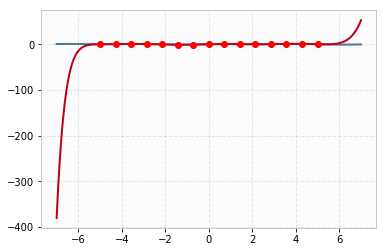

In [14]:
ex = 2
x = np.linspace(-scale - ex, scale + ex, 10000)
y = complex_func(x/scale)
approx_y = calc_apprximant(p_herm, alpha, x)
plt.plot(x, y, x, approx_y, nodes, RH, 'ro');

### Uniform distribution

In tha case of uniform distribution we use Legendre polynomials
$$
\int_{-1}^1p_n(x)p_m(x)\,dx=\frac2{2n+1}\delta_{nm}
$$

In [15]:
from numpy.polynomial import Legendre
def p_legendre(x, n, interval=(-1.0, 1.0)):
    """
    Non-normed Legendre poly.
    """
    xn = (interval[0] + interval[1] - 2.0*x)/(interval[0] - interval[1])
    return Legendre.basis(n)(xn)

def p_legendre_snorm(n, interval=(-1.0, 1.0)):
    """
    RETURNS E[L_n L_n]
    """
    return (interval[1] - interval[0])/(2.0*n + 1.0)


In [16]:
n = 15
M = n

nodes = np.linspace(-1, 1,  M)
RH = complex_func(nodes)
A = system_mat(nodes, n, p_legendre)

if n == M:
    alpha = np.linalg.solve(A, RH)
else:
    alpha = np.linalg.lstsq(A, RH)[0]
    
h = np.array([p_legendre_snorm(i) for i in range(len(alpha))])
var = np.sum(alpha[1:]**2*h[1:])

print ("mean = {}, variance = {}".format(alpha[0]*h[0], var))

mean = 0.171641794164, variance = 0.465615748557


The precise values are
$$
\mathbb E f = 0.1700970689187\ldots,
\qquad 
\text{Var }f= 0.4806857166498\ldots
$$